# Entrenando un modelo de IA!

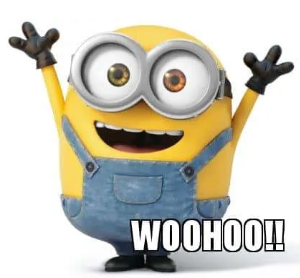


In [ ]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [ ]:
pipeline_result = pipeline(
    training='dataset/full_triples.tsv',
    testing='dataset/fullgraph_triples_validation.tsv',
    model="TransH",
    # Training configuration
    training_kwargs=dict(
        num_epochs=100,
        use_tqdm_batch=False,
    ),
    # Runtime configuration
    random_seed=1234,
    device="gpu", #cpu
)

In [ ]:
grupo_nro = 1
pipeline_result.save_to_directory(f'models/inmuebles_grupo_{grupo_nro:02}')

In [ ]:
model = torch.load('models/inmuebles_grupo_01/trained_model.pkl')

In [ ]:
triples_file = 'dataset/sameas_test.tsv'
triples_factory = TriplesFactory.from_path(triples_file,create_inverse_triples=True)

In [ ]:
triples_factory.relation_to_id['http://www.w3.org/2002/07/owl#sameAs']

In [ ]:
df = pd.read_csv(triples_file, sep='\t', header=None, names=['head', 'relation', 'tail'])
heads = df['head'].tolist()
relations = df['relation'].tolist()

heads_idx = [triples_factory.entity_to_id[head] for head in heads]
relations_idx = [triples_factory.relation_to_id[relation] for relation in relations]

hr_batch = torch.tensor(list(zip(heads_idx, relations_idx)))

In [ ]:
scores = model.score_t(hr_batch)
triples_factory

In [ ]:
same_as_relation_id = triples_factory.relation_to_id['http://www.w3.org/2002/07/owl#sameAs']
heads = df['head'].tolist()
heads_idx = [triples_factory.entity_to_id[head] for head in heads]
relations_idx = [same_as_relation_id] * len(heads_idx)
hr_batch = torch.tensor(list(zip(heads_idx, relations_idx)))

In [ ]:
best_tail_indices = torch.argmax(scores, dim=1)
best_tail_indices

In [ ]:
best_tails = [triples_factory.entity_id_to_label[idx.item()] for idx in best_tail_indices]
for head, tail in zip(heads, best_tails):
    print(f'{head} owl:sameAs {tail}')

In [ ]:
threshold = 0.

# Filtrar las colas cuya puntuación sea mayor al umbral
for i, head in enumerate(heads):
    # Obtener las puntuaciones para el par (head, owl:sameAs)
    score_row = scores[i]
    
    # Filtrar los índices de colas que superan el umbral
    valid_tail_indices = (score_row < threshold).nonzero(as_tuple=True)[0]
    
    # Obtener los nombres de las colas filtradas
    valid_tails = [triples_factory.entity_id_to_label[idx.item()] for idx in valid_tail_indices]
    
    # Mostrar las colas filtradas para el head actual
    if valid_tails:
        print(f'{head} owl:sameAs {valid_tails}')
    else:
        print(f'{head} owl:sameAs None (No tails above threshold)')